In [ ]:
# library imports
import os
import glob2
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import PIL
import cv2
import scipy.ndimage

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
# data loading
image_dir = Path('/content/mydrive/MyDrive/archive')

# get filepaths and labels
filepaths1 = list(image_dir.glob(r'**/*.png'))
filepaths2 = list(image_dir.glob(r'**/*.jpg'))
filepaths = filepaths1 + filepaths2

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

# generating text file for annotations
unique_list = image_df['Label'].unique().tolist()
classes = len(unique_list)

with open('/content/mydrive/MyDrive/archive.txt', 'w') as filehandle:
    for listitem in unique_list:
        filehandle.write('%s\n' % listitem)

In [ ]:

# shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# show the result
image_df.head()

,Filepath,Label
0,/content/mydrive/MyDrive/archive/Lumpy Skin Im...,Lumpy Skin
1,/content/mydrive/MyDrive/archive/Lumpy Skin Im...,Lumpy Skin
2,/content/mydrive/MyDrive/archive/Lumpy Skin Im...,Normal Skin
3,/content/mydrive/MyDrive/archive/Lumpy Skin Im...,Normal Skin
4,/content/mydrive/MyDrive/archive/Lumpy Skin Im...,Lumpy Skin


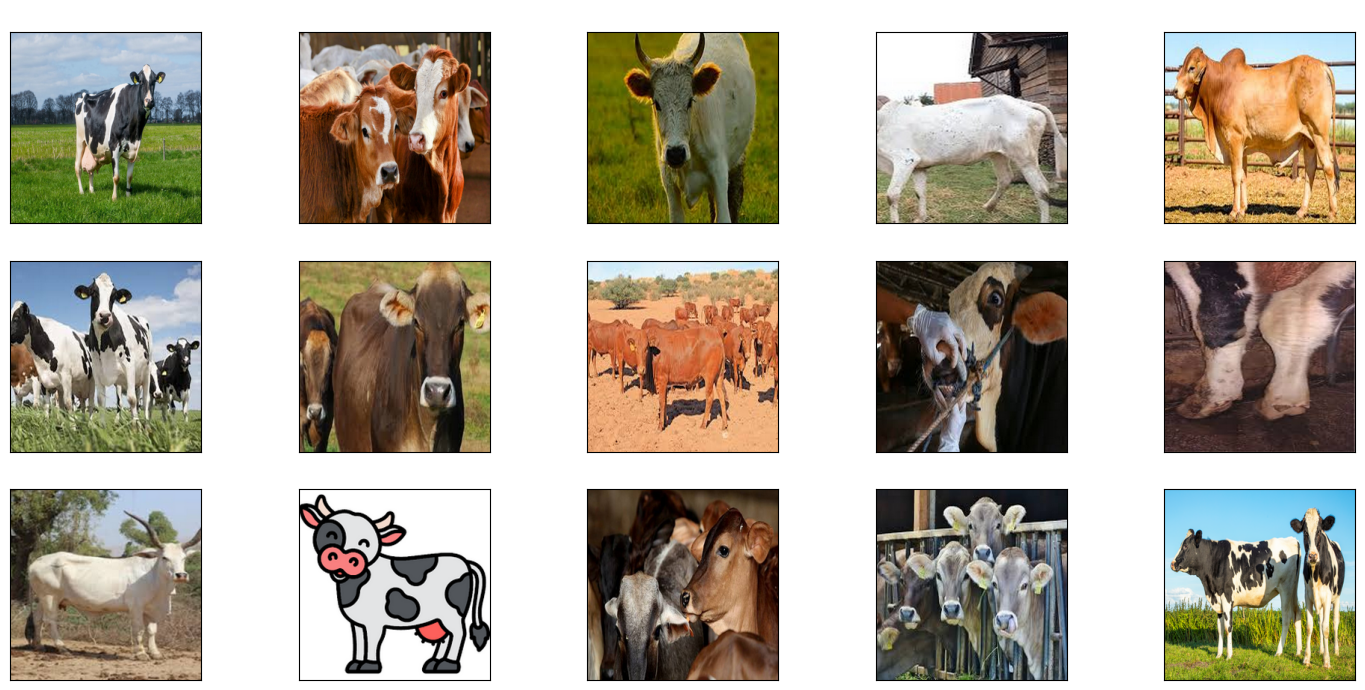

In [ ]:
# display 15 picture of the dataset with their labels
from turtle import color

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for b, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[b]))
    ax.set_title(image_df.Label[b], color='white')
plt.tight_layout()
plt.show()

<ipython-input-6-3ab32aaffa1a>:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, PIL.Image.ANTIALIAS)


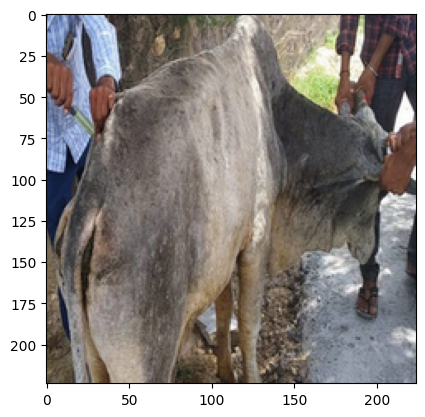

In [ ]:
#preprocessing involves filtering and resizing
# Resize and filter images
resized_images = []

target_size = (224, 224)  # Set your target size for resizing

for filepath in glob2.glob('/content/mydrive/MyDrive/archive'):
    img = PIL.Image.open('/content/mydrive/MyDrive/archive/Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin.png')
    img = img.resize(target_size, PIL.Image.ANTIALIAS)
    resized_images.append(np.array(img))
    img = scipy.ndimage.gaussian_filter(img, sigma=3)
    resized_images.append(np.array(img))
resized_images = np.array(resized_images)

# Display resized images
plt.imshow(resized_images[0])
plt.show()

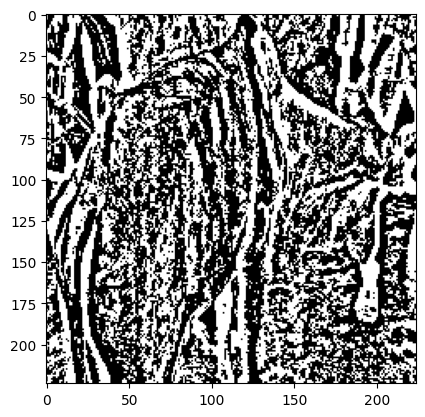

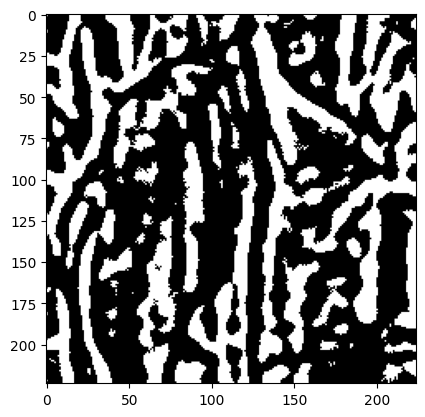

In [ ]:
# Loop through each resized image
for img in resized_images:
    # Convert the image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Show the segmented image
    plt.imshow(thresh, cmap='gray')
    plt.show()

In [ ]:
def extract_features(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extract HOG features
    hog = cv2.HOGDescriptor()
    features = hog.compute(gray)

    return features

In [ ]:
features = []

# Loop through each resized image
for img in resized_images:
    # Extract HOG features
    features.append(extract_features(img))

# Print the extracted features
print(features)
plt.show()


[array([0.12779811, 0.25375065, 0.23739585, ..., 0.14984687, 0.19323027,
       0.2779146 ], dtype=float32), array([0.11826969, 0.02573171, 0.00140175, ..., 0.20117351, 0.06451038,
       0.05776899], dtype=float32)]


In [ ]:
# separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2,horizontal_flip=True, vertical_flip=True,rescale=1.255,fill_mode='nearest'
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,rescale=1.255
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 567 validated image filenames belonging to 2 classes.
Found 141 validated image filenames belonging to 2 classes.
Found 177 validated image filenames belonging to 2 classes.


In [ ]:
# loading the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max',
    classes=2
)

pretrained_model.trainable = False

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
# model architecture & training
inputs = pretrained_model.input

x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=1,
    #         restore_best_weights=True
    #     )
    # ]
)

Epoch 1/10
18/18 [==============================] - 210s 11s/step - loss: 0.7695 - accuracy: 0.7443 - val_loss: 0.4344 - val_accuracy: 0.8227
Epoch 2/10
18/18 [==============================] - 148s 8s/step - loss: 0.4811 - accuracy: 0.8060 - val_loss: 0.3984 - val_accuracy: 0.8652
Epoch 3/10
18/18 [==============================] - 157s 9s/step - loss: 0.3366 - accuracy: 0.8589 - val_loss: 0.3086 - val_accuracy: 0.8582
Epoch 4/10
18/18 [==============================] - 154s 9s/step - loss: 0.4134 - accuracy: 0.8413 - val_loss: 0.3182 - val_accuracy: 0.8794
Epoch 5/10
18/18 [==============================] - 156s 9s/step - loss: 0.3721 - accuracy: 0.8430 - val_loss: 0.3222 - val_accuracy: 0.8723
Epoch 6/10
18/18 [==============================] - 144s 8s/step - loss: 0.2381 - accuracy: 0.8942 - val_loss: 0.3538 - val_accuracy: 0.8794
Epoch 7/10
18/18 [==============================] - 151s 8s/step - loss: 0.2130 - accuracy: 0.9083 - val_loss: 0.2409 - val_accuracy: 0.8794
Epoch 8/10
1

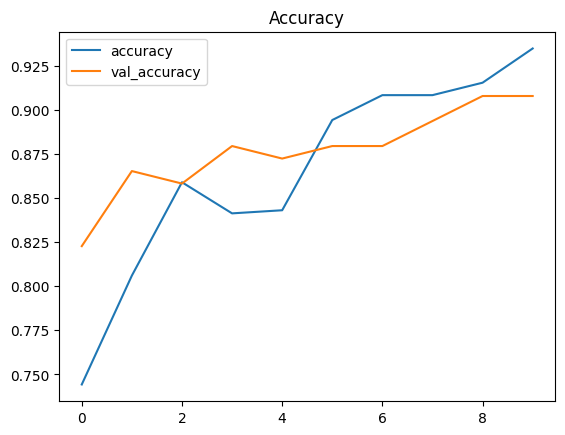

In [ ]:
# accuracy visualization
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

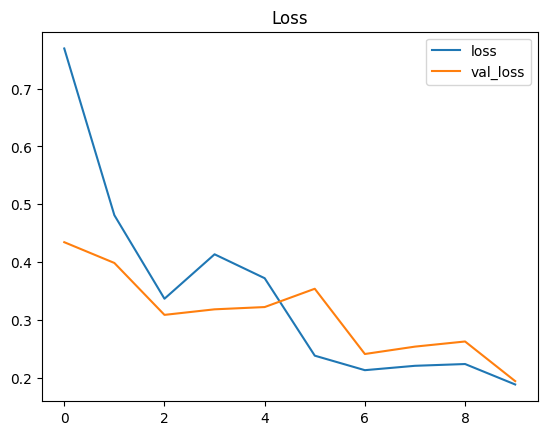

In [ ]:
# loss visualization
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

1/1 [==============================] - 5s 5s/step


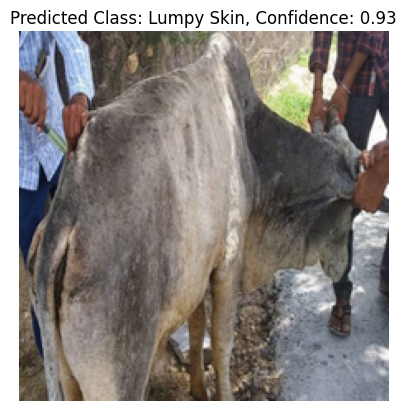

In [ ]:
# Load a single image
image_path = '/content/mydrive/MyDrive/archive/Lumpy Skin Images Dataset/Lumpy Skin/Lumpy_Skin.png'
 # Replace 'path_to_your_single_image.jpg' with the actual path of your image
image = PIL.Image.open(image_path)
image = image.resize((224, 224))  # Resize the image to match the input size of the model

# Preprocess the image
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)  # Add batch dimension
preprocessed_image = tf.keras.applications.efficientnet.preprocess_input(image_array)

# Predict the class probabilities
predictions = model.predict(preprocessed_image)
predicted_class_index = np.argmax(predictions[0])
predicted_class_confidence = predictions[0][predicted_class_index]

# Get the predicted class label
class_labels = train_images.class_indices
predicted_class_label = list(class_labels.keys())[predicted_class_index]

# Display the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class_label}, Confidence: {predicted_class_confidence:.2f}')
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 144ms/step


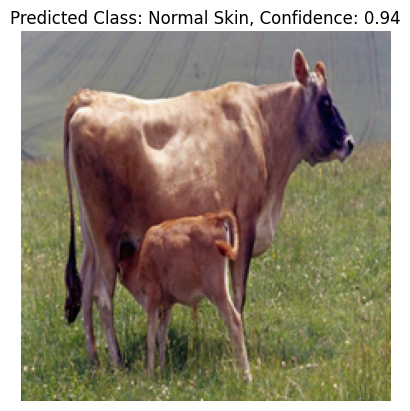

In [ ]:
# Load a single image
image_path = '/content/mydrive/MyDrive/archive/Lumpy Skin Images Dataset/Normal Skin/Normal_Skin.png'
 # Replace 'path_to_your_single_image.jpg' with the actual path of your image
image = PIL.Image.open(image_path)
image = image.resize((224, 224))  # Resize the image to match the input size of the model

# Preprocess the image
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)  # Add batch dimension
preprocessed_image = tf.keras.applications.efficientnet.preprocess_input(image_array)

# Predict the class probabilities
predictions = model.predict(preprocessed_image)
predicted_class_index = np.argmax(predictions[0])
predicted_class_confidence = predictions[0][predicted_class_index]

# Get the predicted class label
class_labels = train_images.class_indices
predicted_class_label = list(class_labels.keys())[predicted_class_index]

# Display the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class_label}, Confidence: {predicted_class_confidence:.2f}')
plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the saved file
model = load_model("/content/mydrive/MyDrive/results/DenseNet.h5")

# Now you can use the model for prediction or further training

In [ ]:
pip install streamlit

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("/content/drive/MyDrive/results/DenseNet.h5")

def preprocess_image(image):
    # Resize the image to match the input size of the model
    image = image.resize((224, 224))
    # Preprocess the image
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = np.expand_dims(image_array, 0)  # Add batch dimension
    preprocessed_image = tf.keras.applications.efficientnet.preprocess_input(image_array)
    return preprocessed_image

def predict(image, train_images):
    # Preprocess the image
    preprocessed_image = preprocess_image(image)
    # Predict the class probabilities
    predictions = model.predict(preprocessed_image)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_confidence = predictions[0][predicted_class_index]
    # Get the predicted class label
    class_labels = train_images['class_indices']  # Access class indices correctly
    predicted_class_label = list(class_labels.keys())[predicted_class_index]
    return predicted_class_label, predicted_class_confidence

# Streamlit App
st.title("Lumpy Disease Detection")

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    st.write("")
    st.write("Classifying...")
    # Define train_images with some example data
    class_indices = {'lumpy_skin': 0, 'normal_skin': 1}  # Example class indices
    train_images = {'class_indices': class_indices}  # Example train_images data

    # Now, you can call the predict function with train_images
    predicted_class_label, predicted_class_confidence = predict(image, train_images)

    st.write(f'Predicted Class: {predicted_class_label}')

Overwriting app.py


In [ ]:
#%%writefile app.py
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image as img
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('/content/drive/MyDrive/results/DenseNet.h5')

# Function to preprocess the image
def preprocess_image(image):
    img_array = img.img_to_array(image)
    img_array = tf.image.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict(image):
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    return prediction

# Streamlit UI
st.title('Lumpy Disease Prediction')

st.write('Upload an image of skin (normal or lumpy)')

uploaded_image = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_image is not None:
    image = Image.open(uploaded_image)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    prediction = predict(image)
    if prediction[0][0] > 0.5:
        st.write('Prediction: Lumpy Disease')
    else:
        st.write('Prediction: Normal Skin')

2024-05-10 08:50:57.314 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.171.0.14


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501
#click on your url is,then paste the password as above ipv4 address()




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.202.55:8501

npx: installed 22 in 3.791s
your url is: https://orange-spoons-push.loca.lt
2024-05-28 06:22:58.770429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 06:22:58.770516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 06:22:58.774035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 06:22:58.790631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimiz